# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [74]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os

from tqdm.notebook import tqdm

/local/scratch/klawren/slrmtmp.47791421/ipykernel_27049/39787421.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [19]:
gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.annotation.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.annotation.gtf"

v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_analysis"

### comparison of gencode annotations

In [3]:
# load in gencode for lncRNA annotations
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()

In [4]:
# drop duplicates (multiple transcripts of same gene)
gencode_v39 = gencode_v39.drop_duplicates('gene_id')
gencode_v47 = gencode_v47.drop_duplicates('gene_id')

In [5]:
# harmonize annotation categories as in https://www.gencodegenes.org/pages/biotypes.html
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', gencode_v39['gene_type'])
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', gencode_v39['gene_type_harmonized'])

In [6]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type').size(), 'v39':gencode_v39.groupby('gene_type_harmonized').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47791421/ipykernel_27049/3796981686.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


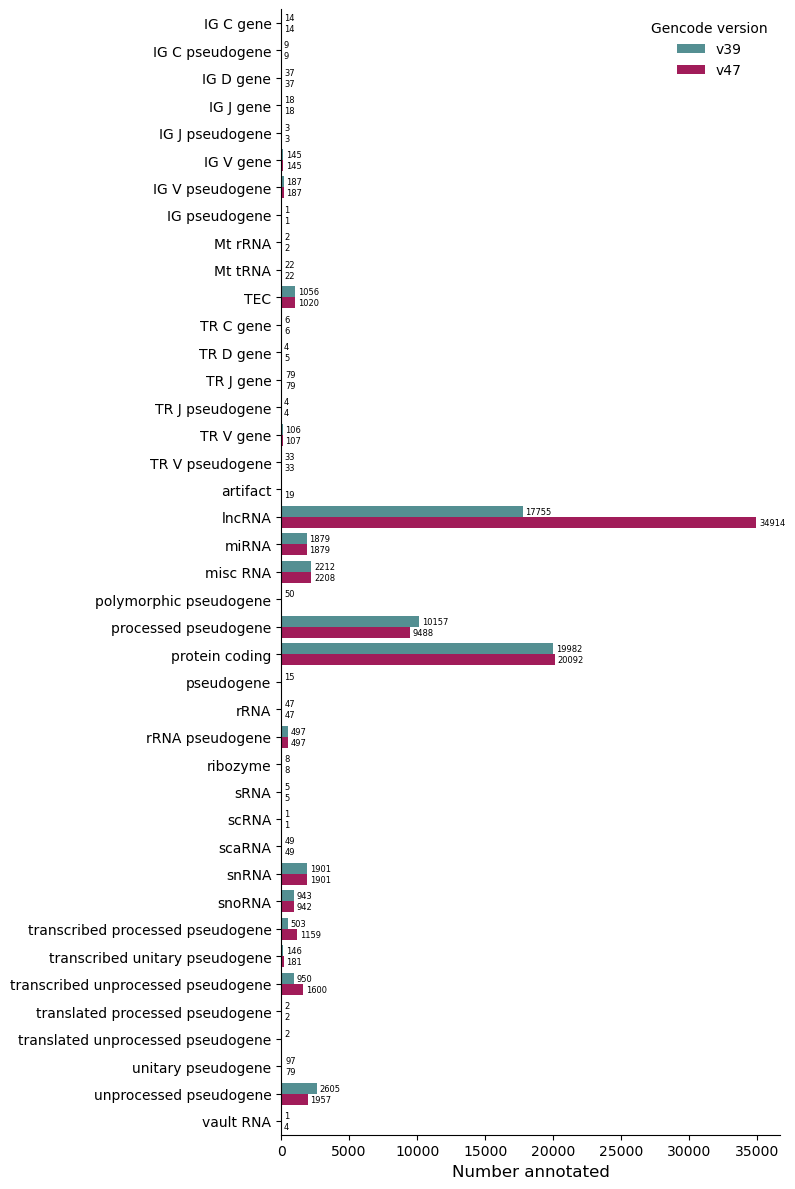

In [7]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

#ax.set_xscale('log')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [8]:
# group some categories 
def group_gene_type(gencode_df):
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_rRNA',
                                                                                            'Mt_tRNA',
                                                                                            'miRNA',
                                                                                            'misc_RNA',
                                                                                            'rRNA',
                                                                                            'scRNA',
                                                                                            'snRNA',
                                                                                            'snoRNA',
                                                                                            'ribozyme',
                                                                                            'sRNA',
                                                                                            'scaRNA',
                                                                                            'vault_RNA']), 'noncoding_RNA', gencode_df['gene_type_harmonized'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_tRNA_pseudogene',
                                                                                            'tRNA_pseudogene',
                                                                                            'snoRNA_pseudogene',
                                                                                            'snRNA_pseudogene',
                                                                                            'scRNA_pseudogene',
                                                                                            'rRNA_pseudogene',
                                                                                            'misc_RNA_pseudogene',
                                                                                            'miRNA_pseudogene']), 'noncoding_RNA_pseudogene', gencode_df['gene_type_grouped'])
    

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_grouped'].isin(['noncoding_RNA_pseudogene']),'noncoding_RNA', gencode_df['gene_type_grouped'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['transcribed_processed_pseudogene',
                                                                                            'transcribed_unprocessed_pseudogene',
                                                                                            'transcribed_unitary_pseudogene',
                                                                                            'translated_processed_pseudogene',
                                                                                            'translated_unprocessed_pseudogene',
                                                                                            'unitary_pseudogene',
                                                                                            'unprocessed_pseudogene',
                                                                                            'pseudogene',
                                                                                            'polymorphic_pseudogene',
                                                                                            'processed_pseudogene',
                                                                                            'IG_C_pseudogene', 
                                                                                            'IG_J_pseudogene', 
                                                                                            'IG_V_pseudogene', 
                                                                                            'IG_pseudogene',
                                                                                            'TR_V_pseudogene',
                                                                                            'TR_J_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['protein_coding', 
                                                                                        'TEC',
                                                                                        'IG_C_gene', 
                                                                                        'IG_D_gene', 
                                                                                        'IG_J_gene',
                                                                                        'IG_V_gene', 
                                                                                        'TR_C_gene',
                                                                                        'TR_J_gene',
                                                                                        'TR_V_gene',
                                                                                        'TR_D_gene']), 'protien_coding_or_TEC', gencode_df['gene_type_grouped'])


In [9]:
gencode_v47['gene_type_harmonized'] = gencode_v47['gene_type']
group_gene_type(gencode_v47)
group_gene_type(gencode_v39)

gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type_grouped').size(), 'v39':gencode_v39.groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47791421/ipykernel_27049/3628803940.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


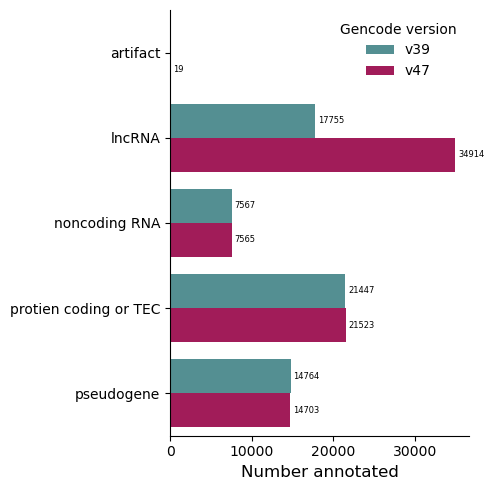

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

### comparison of lnc RNAs we detect

In [11]:
tpm_cutoff=.1
gene_type_order = ['lncRNA', 'protien_coding_or_TEC', 'pseudogene', 'noncoding_RNA', 'artifact']

gene_type_pal = {'lncRNA':'#b70657',
                 'protien_coding_or_TEC':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}


highlight_gene_type_pal = {'new_lncRNA':'#fb7cb6', 
                           'lncRNA':'#b70657',
                 'protien_coding_or_TEC':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}

In [12]:
# aggregate quantifications from the output directory
# final output should be dataframe with sample_id as columns and gene_tpm

def agg_rnaseqc(output_dir, file_end='.gene_tpm.gct.gz'):
    sample_tpms = []
    for filename in os.listdir(os.path.join(output_dir, 'rnaseq_qc')):
            if filename.endswith(file_end):
                print(filename)
                sample_tpms.append(pd.read_csv(os.path.join(output_dir, f'rnaseq_qc/{filename}'), sep='\t', skiprows=2).set_index(['Name', 'Description']))

    tpm_agg = pd.concat(sample_tpms, axis=1).reset_index()
    return tpm_agg

In [22]:
tpm_v11 = agg_rnaseqc(v11_quantificaiton_dir)
tpm_v11.to_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_tpm_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)
tpm_v11 = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_tpm_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
tpm_v11.head()


GTEX-13PL6-0011-R5b-SM-5O9BI.gene_tpm.gct.gz
GTEX-1EH9U-0011-R5a-SM-CJI2K.gene_tpm.gct.gz
GTEX-13OW7-0011-R5b-SM-5O9DM.gene_tpm.gct.gz
GTEX-12584-0011-R5b-SM-GIN96.gene_tpm.gct.gz
GTEX-UTHO-0011-R5A-SM-G8W6H.gene_tpm.gct.gz
GTEX-13VXU-0011-R5a-SM-5O9D7.gene_tpm.gct.gz
GTEX-11GSP-0011-R5a-SM-57WBE.gene_tpm.gct.gz
GTEX-NL3H-0011-R5a-SM-2I3GB.gene_tpm.gct.gz
GTEX-T2IS-0011-R5A-SM-32QP4.gene_tpm.gct.gz
GTEX-14BIM-0011-R5b-SM-5S2RM.gene_tpm.gct.gz
GTEX-13SLX-0011-R5a-SM-5O9BV.gene_tpm.gct.gz
GTEX-13112-0011-R5b-SM-5DUV8.gene_tpm.gct.gz
GTEX-117XS-0011-R5b-SM-GJ3PP.gene_tpm.gct.gz
GTEX-1GPI6-0011-R5a-SM-CJI2W.gene_tpm.gct.gz
GTEX-T6MN-0011-R5A-SM-32QPD.gene_tpm.gct.gz
GTEX-QVJO-0011-R5A-SM-2S1QM.gene_tpm.gct.gz
GTEX-1117F-0011-R5a-SM-GI4VW.gene_tpm.gct.gz
GTEX-1HCU6-0011-R5a-SM-ARU76.gene_tpm.gct.gz
GTEX-1I1GQ-0011-R5a-SM-CMKHJ.gene_tpm.gct.gz
GTEX-15DYW-0011-R5a-SM-6M46W.gene_tpm.gct.gz
GTEX-ZXG5-0011-R5b-SM-57WBN.gene_tpm.gct.gz
GTEX-1N2DW-0011-R5a-SM-EYYX3.gene_tpm.gct.gz
GTEX-1GZ4I-0011-

,Name,Description,GTEX-13PL6-0011-R5b-SM-5O9BI,GTEX-1EH9U-0011-R5a-SM-CJI2K,GTEX-13OW7-0011-R5b-SM-5O9DM,GTEX-12584-0011-R5b-SM-GIN96,GTEX-UTHO-0011-R5A-SM-G8W6H,GTEX-13VXU-0011-R5a-SM-5O9D7,GTEX-11GSP-0011-R5a-SM-57WBE,GTEX-NL3H-0011-R5a-SM-2I3GB,...,GTEX-1N2EE-0011-R5a-SM-EY5YF,GTEX-11NV4-0011-R5a-SM-5NQ88,GTEX-1192W-0011-R5a-SM-GI4VY,GTEX-1GZ2Q-0011-R5a-SM-A96RQ,GTEX-WL46-0011-R5A-SM-3LK6V,GTEX-11DXY-0011-R5b-SM-DNZZL,GTEX-12ZZZ-0011-R5a-SM-5EQ4M,GTEX-11ONC-0011-R5b-SM-DO93I,GTEX-13N1W-0011-R5b-SM-5MR5Q,GTEX-1KD4Q-0011-R5a-SM-EY5Y8
0,ENSG00000290825.2,DDX11L16,0.016976,0.000000,0.000000,0.000000,0.011532,0.000000,0.000000,0.015858,...,0.000000,0.000000,0.000000,0.01603,0.000000,0.014490,0.019261,0.000000,0.035504,0.011702
1,ENSG00000223972.6,DDX11L1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSG00000310526.1,WASH7P,0.570455,0.362674,0.854803,0.413729,1.291690,0.480483,1.053108,1.494747,...,1.381221,1.126558,0.585683,0.84693,1.096104,0.912594,0.765295,0.849347,1.763305,0.420427
3,ENSG00000243485.6,MIR1302-2HG,0.029428,0.015024,0.015720,0.018853,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000237613.3,FAM138A,0.064292,0.009378,0.029438,0.035304,0.012478,0.013977,0.026174,0.051477,...,0.015645,0.000000,0.000000,0.00000,0.000000,0.000000,0.020842,0.000000,0.019208,0.037986


In [23]:
# load in tpm quantification for v10
tpm_v10 = pd.read_csv(v10_quantificaiton_path, sep='\t', skiprows=2)
# replace the sample ids to match the format in v11
# tpm_v10.columns = tpm_v10.columns.str.replace('-R5a-', '', regex=False)
tpm_v10.head()

,Name,Description,GTEX-1117F-0011-R5a-SM-GI4VW,GTEX-111FC-0011-R5a-SM-GIN8L,GTEX-117XS-0011-R5b-SM-GJ3PP,GTEX-1192W-0011-R5a-SM-GI4VY,GTEX-1192X-0011-R5a-SM-DNZZA,GTEX-11DXW-0011-R5b-SM-DO11D,GTEX-11DXY-0011-R5b-SM-DNZZL,GTEX-11DYG-0011-R5a-SM-DO928,...,GTEX-ZE9C-0011-R5a-SM-5EGLO,GTEX-ZF28-0011-R5a-SM-4WWCZ,GTEX-ZUA1-0011-R5b-SM-51MTG,GTEX-ZV68-0011-R5a-SM-4YCDW,GTEX-ZVT3-0011-R5a-SM-51MSI,GTEX-ZVZQ-0011-R5b-SM-57WDC,GTEX-ZXG5-0011-R5b-SM-57WBN,GTEX-ZYFD-0011-R5a-SM-H6Q7M,GTEX-ZYY3-0011-R5a-SM-H7OGH,GTEX-ZZPT-0011-R5a-SM-GPRX5
0,ENSG00000223972.5,DDX11L1,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.033181,0.013432,0.010025,0.012049,0.025464
1,ENSG00000227232.5,WASH7P,3.51443,3.443050,2.843570,2.49813,2.098910,0.799514,2.53661,1.20675,...,0.774938,2.06256,1.604420,1.209580,1.01061,1.814390,1.923700,1.109440,1.302020,1.624510
2,ENSG00000278267.1,MIR6859-1,0.00000,0.365439,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000243485.5,MIR1302-2HG,0.00000,0.028695,0.057756,0.00000,0.058521,0.043787,0.00000,0.00000,...,0.086953,0.00000,0.119049,0.033725,0.00000,0.033123,0.000000,0.000000,0.024056,0.025420
4,ENSG00000237613.2,FAM138A,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.020591,0.00000,0.000000,0.047918,0.00000,0.023531,0.000000,0.000000,0.000000,0.000000


In [24]:
# check v10 gene_ids are all in v39 gencode
print('{} v10 gene ids aren\'t in gencode v39'.format(sum(~tpm_v10['Name'].isin(gencode_v39['gene_id']))))
# check v11 gene_ids are all in v47 gencode
print('{} v11 gene ids aren\'t in gencode v47'.format(sum(~tpm_v11['Name'].isin(gencode_v47['gene_id']))))


# get only the sample ids in both (should be all of them)
v10_sample_ids = tpm_v10.columns[2:]
v11_sample_ids = tpm_v11.columns[2:]

# TODO confirm that all samples match between v10 and v11
print('{} v10 ids arent in v11'.format(len(v10_sample_ids[~v10_sample_ids.isin(v11_sample_ids)])))
print('{} v11 ids arent in v10'.format(len(v11_sample_ids[~v11_sample_ids.isin(v10_sample_ids)])))

both_ids = v11_sample_ids[v11_sample_ids.isin(v10_sample_ids)]
print('{} ids in both'.format(len(both_ids)))
v10_sample_ids = both_ids
v11_sample_ids = both_ids


0 v10 gene ids aren't in gencode v39
0 v11 gene ids aren't in gencode v47
0 v10 ids arent in v11
22 v11 ids arent in v10
300 ids in both


In [25]:
# get mean tpm for v10
v10_mean_tpm = pd.DataFrame({'gene_id':tpm_v10['Name'], 'tpm':tpm_v10[v10_sample_ids].mean(axis=1)})
v10_mean_tpm = pd.merge(left=v10_mean_tpm, right=gencode_v39[['gene_id', 'gene_type_grouped']], on='gene_id', how='left')
v10_mean_tpm['quantified'] = v10_mean_tpm['tpm']>tpm_cutoff

Text(0.15000000000000002, 2499.525, 'quantified')

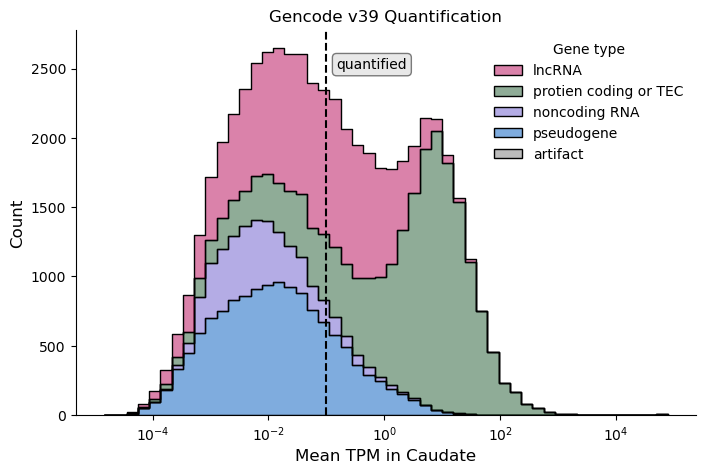

In [26]:
# v10 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v10_mean_tpm, x='tpm', hue='gene_type_grouped', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys())[1:])

ax.set_xlabel('Mean TPM in Caudate', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode v39 Quantification')


# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

ax.axvline(tpm_cutoff, color='k', linestyle='--')
ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [121]:
# get v11 data
v11_mean_tpm = pd.DataFrame({'gene_id':tpm_v11['Name'], 'tpm':tpm_v11[v11_sample_ids].mean(axis=1)})
v11_mean_tpm = pd.merge(left=v11_mean_tpm, right=gencode_v47[['gene_id', 'gene_type_grouped']], on='gene_id', how='left')

# get a list of the new lncRNAs
new_lncrnas = gencode_v47[gencode_v47['gene_type_grouped']=='lncRNA']['gene_id']
new_lncrnas = new_lncrnas[~new_lncrnas.isin(gencode_v39['gene_id'])]

# add info about new lncRNAs
v11_mean_tpm['new_highlight_gene_type'] = np.where(v11_mean_tpm['gene_id'].isin(new_lncrnas), 'new_lncRNA', v11_mean_tpm['gene_type_grouped'])
v11_mean_tpm['quantified'] = v11_mean_tpm['tpm']>tpm_cutoff

Text(0.15000000000000002, 3599.505, 'quantified')

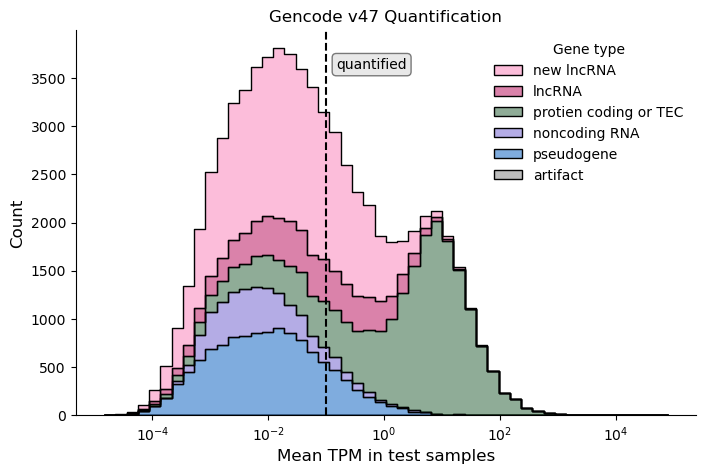

In [28]:
# v11 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v11_mean_tpm, x='tpm', hue='new_highlight_gene_type', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=highlight_gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys()))

ax.set_xlabel('Mean TPM in test samples', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode v47 Quantification')

# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

ax.axvline(tpm_cutoff, color='k', linestyle='--')
ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [29]:
# combine the two versions
mean_tpm_combined = pd.merge(left=v10_mean_tpm, right=v11_mean_tpm, on='gene_id', suffixes=['_v10', '_v11'], how='right')
mean_tpm_combined['quantified_v10'] = mean_tpm_combined['quantified_v10'].fillna(False)
# rename for upset plot
quantified_mean_tpm = mean_tpm_combined[(mean_tpm_combined['quantified_v10']) | (mean_tpm_combined['quantified_v11'])]
quantified_mean_tpm = quantified_mean_tpm.rename(columns={'quantified_v10':'v10','quantified_v11':'v11'})
upset_tpm_bool = quantified_mean_tpm.set_index('v10').set_index('v11', append=True)

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


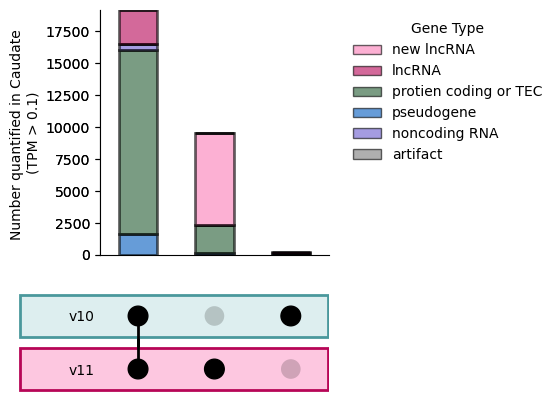

In [30]:
fig = plt.figure(figsize=(4,5))

upset = up.UpSet(upset_tpm_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=False, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="new_highlight_gene_type", title="", elements=4, colors=highlight_gene_type_pal, )
plot_result = upset.plot(fig=fig)

# add category colors
upset.style_categories("v10", shading_edgecolor='#4a989c', shading_linewidth=2, shading_facecolor='#ddeeef')
upset.style_categories("v11", shading_edgecolor='#b70657', shading_linewidth=2, shading_facecolor='#fdc7e0')

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel("Number quantified in Caudate \n(TPM > 0.1)")
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# optional add bar labels
# for container in stackedbar_plot.containers:
#     stackedbar_plot.bar_label(container, label_type='center', color='k', rotation=45, fontsize=5)


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=highlight_gene_type_pal[gene_type], edgecolor='k', alpha=.6) for gene_type in ['new_lncRNA', *gene_type_order]]
labels = [label.replace('_', ' ') for label in ['new_lncRNA', *gene_type_order]]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()


In [31]:
def ridgeline(data, overlap=0, fill=True, use_labels=False, labels=None, n_points=150, colors=None, zorder=0, edgecolor='k', ax=None):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, use color to fill the distributions?
    use_labels, use y axis labels?
    labels, values to place on the y axis to describe the distributions.
    n_points, number of points to evaluate each distribution function.
    colors, single or list for each distribution
    zorder, offest all items up or down
    edgecolor, for the distributions
    """
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,5))
    if colors == None:
        colors=['blue']*len(data)

    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        if fill:
            ax.fill_between(xx, np.ones(n_points)*y, 
                             curve+y, zorder=len(data)-i+1+zorder, color=colors[i], alpha=.6)
        ax.plot(xx, curve+y, c=edgecolor, zorder=len(data)-i+1+zorder, lw=2)
    if use_labels:
        ax.set_yticks(ys, labels)
        ax.yaxis.set_tick_params(length=0)
        for tick, color in zip(ax.yaxis.get_major_ticks(), colors):
            tick.label1.set_color(color)

    ax.spines[['top', 'right', 'left']].set_visible(False)

    return ax

In [32]:
ridgeline_grouped_v10 = v10_mean_tpm[v10_mean_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index()
# TODO this iloc bit drops aritfact as a category, confirm it is still doing that if input data changes
ridgeline_grouped_v11 = v11_mean_tpm[v11_mean_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index().iloc[1:]

In [33]:
def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_tuple  = hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

gene_type_colors = [alpha_blending(gene_type_pal[gene_type], .7) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]
gene_type_colors_light = [alpha_blending(gene_type_pal[gene_type], .3) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]


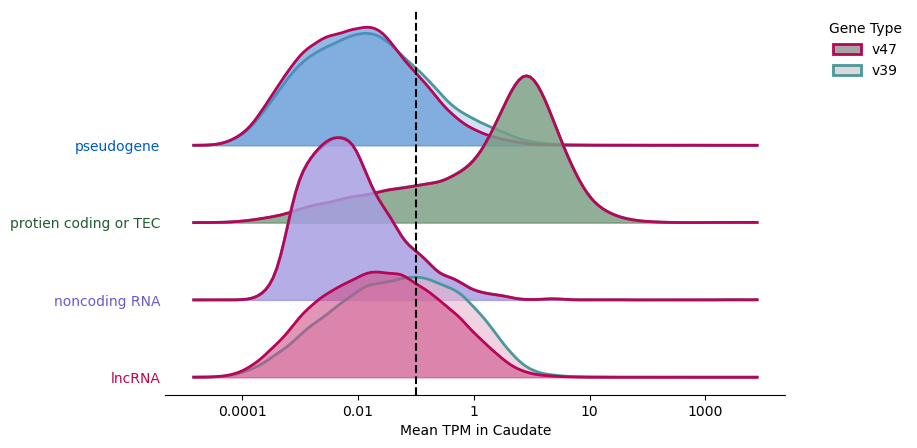

In [34]:
pretty_ylabels = [label.replace('_', ' ') for label in ridgeline_grouped_v10['gene_type_grouped'].values]
ax = ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v10['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors_light, zorder=0, edgecolor='#4a989c')
ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v11['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors, ax=ax, zorder=.5,  edgecolor='#b70657')

ax.axvline(np.log10(tpm_cutoff), color='k', linestyle='--', zorder=10)
ax.set_xlabel('Mean TPM in Caudate')

ax.set_xticks([-4, -2, 0, 2, 4], labels=['0.0001', '0.01', '1', '10', '1000'])


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=fc, edgecolor=ec, linewidth=2) for fc, ec in zip([alpha_blending('grey', .7), alpha_blending('grey', .3)], ['#b70657', '#4a989c'])]
labels = ['v47', 'v39']
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

# make colors darker
for tick, color in zip(ax.yaxis.get_major_ticks(), [gene_type_pal[gene_type] for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]):
    tick.label1.set_color(color)

plt.show()


#### scatterplot of quantification in one vs the other

In [35]:
mean_tpm_combined = pd.merge(left=v10_mean_tpm, right=v11_mean_tpm, on='gene_id', suffixes=['_v10', '_v11'], how='right')
# fill with 1e-10 for ones that don't exist
mean_tpm_combined[['tpm_v10', 'tpm_v11']] = mean_tpm_combined[['tpm_v10', 'tpm_v11']].fillna(1e-7)
# fill with 1e-5 for ones that exist but weren't found
mean_tpm_combined[['tpm_v10', 'tpm_v11']] = mean_tpm_combined[['tpm_v10', 'tpm_v11']].replace(0, 1e-5)

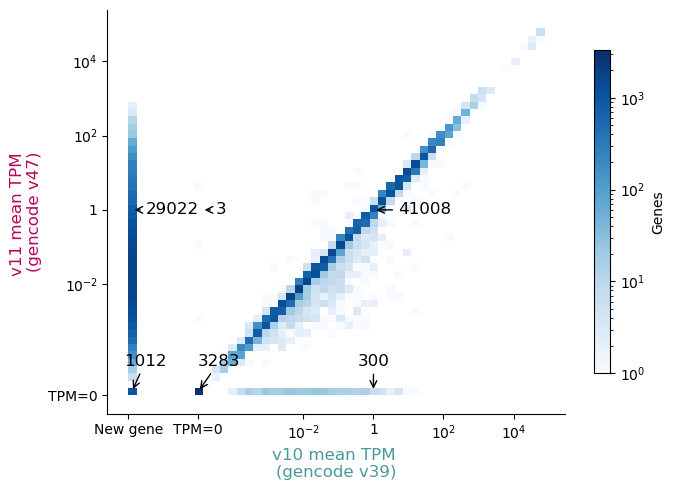

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(mean_tpm_combined, x='tpm_v10', y='tpm_v11', bins=50, norm=LogNorm(), vmin=None, vmax=None, cbar=True, log_scale=True, cmap=sns.color_palette("Blues", as_cmap=True), ax=ax, cbar_kws={'shrink':.8, 'label':'Genes'})

ax.set_xlabel('v10 mean TPM \n(gencode v39)', color='#4a989c', fontsize=12)
ax.set_ylabel('v11 mean TPM \n(gencode v47)', color='#b70657', fontsize=12)

ax.set_xticks([1e-7, 1e-5, 1e-2, 1, 1e2, 1e4], labels=['New gene', 'TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])
ax.set_yticks([1e-5, 1e-2, 1, 1e2, 1e4], labels=['TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])

ax.spines[['top', 'right']].set_visible(False)

# add labels to the number of things in each group
ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']==1e-7)&(mean_tpm_combined['tpm_v11']==1e-5)]), xy=(10**(-6.9),10**(-4.9)), xytext=(10**(-6.5), 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')

ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']==1e-5)&(mean_tpm_combined['tpm_v11']==1e-5)]), xy=(10**(-5),10**(-4.9)), xytext=(10**(-4.4), 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')


ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']>1e-5)&(mean_tpm_combined['tpm_v11']==1e-5)]), xy=(1,10**(-4.9)), xytext=(1, 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')

ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']==1e-7)&(mean_tpm_combined['tpm_v11']>1e-5)]), xy=(10**(-6.9),1), xytext=(10**(-6.5),1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')

ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']==1e-5)&(mean_tpm_combined['tpm_v11']>1e-5)]), xy=(10**(-4.9),1), xytext=(10**(-4.5),1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')

ax.annotate(len(mean_tpm_combined[(mean_tpm_combined['tpm_v10']>1e-5)&(mean_tpm_combined['tpm_v11']>1e-5)]), xy=(1,1), xytext=(5,1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')


fig.tight_layout()

### compare to null distribution 

In [100]:
# aggregate counts
# null_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_nongenic_null"
# null_counts = agg_rnaseqc(null_quantificaiton_dir, file_end='.gene_reads.gct.gz')
# v11_counts = agg_rnaseqc(v11_quantificaiton_dir, file_end='.gene_reads.gct.gz')
# v11_counts.to_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)
# null_counts.to_csv('/home/klawren/oak/gtex/output/caudate_nongenic_null/null_gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)

v11_counts = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
null_counts = pd.read_csv('/home/klawren/oak/gtex/output/caudate_nongenic_null/null_gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')

null_sample_ids = null_counts.columns[2:]
v11_sample_ids = v11_counts.columns[2:]

null_counts = null_counts.set_index('Name').drop(columns='Description')
v11_counts = v11_counts.set_index('Name').drop(columns='Description')

In [122]:
print('{} null ids arent in v11'.format(len(null_sample_ids[~null_sample_ids.isin(v11_sample_ids)])))
print('{} v11 ids arent in null'.format(len(v11_sample_ids[~v11_sample_ids.isin(null_sample_ids)])))

# make them have the same samples
# TODO confirm after pipeline finishes, all samples should be in both and htis should be removed
v11_counts = v11_counts[null_sample_ids]
null_counts = null_counts[null_sample_ids]

# null for mitochondial genes can't work, becuase there isn't wnough null space on the mitochondira
# remove those genes
print('removing {} mito genes that dont have matched null'.format(len(v11_counts[~v11_counts.index.isin(null_counts.index)])) )
v11_counts = v11_counts[v11_counts.index.isin(null_counts.index)]
v11_mean_tpm = v11_mean_tpm[v11_mean_tpm['gene_id'].isin(null_counts.index)]

0 null ids arent in v11
26 v11 ids arent in null
removing 0 mito genes that dont have matched null


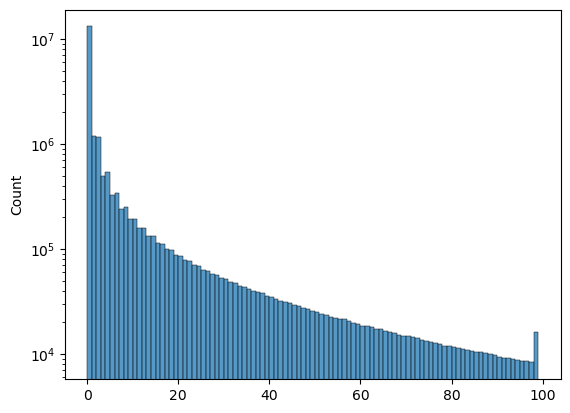

In [42]:
# histplot for all the null
ax = sns.histplot(null_counts[null_sample_ids].values.flatten(), bins=np.arange(0,100,1))
ax.set_yscale('log')

In [108]:
max(v11_counts.loc[sample_gene_id].values)

13

In [111]:
def plot_matched_null(sample_gene_id):
    null_counts_gene  = null_counts.loc[sample_gene_id].values
    v11_counts_gene  = v11_counts.loc[sample_gene_id].values
    stat, p_value = stats.wilcoxon(v11_counts_gene, null_counts_gene, alternative='greater')
    # plot the two distributions for a sample gene
    plot_df = pd.DataFrame({
        'count': np.concatenate([null_counts_gene, v11_counts_gene]),
        'distribution': ['Nongenic null'] * len(null_counts_gene) + ['Gene'] * len(v11_counts_gene)})

    fig, ax = plt.subplots(figsize=(5,3))
    if max(v11_counts_gene) > 30:
        sns.histplot(plot_df,x='count', bins=30, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    else:
        sns.histplot(plot_df,x='count', discrete=True, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene read count in sample')
    ax.set_ylabel('Number of samples')
    # Customize the legend
    legend = ax.get_legend()
    legend.get_frame().set_visible(False)
    legend.set_title("Data type")
    ax.set_title('Quantification {}, p={:.1e}'.format(sample_gene_id, p_value))
    fig.tight_layout()


,gene_id,tpm,gene_type_grouped,new_highlight_gene_type,quantified,matched_null_p


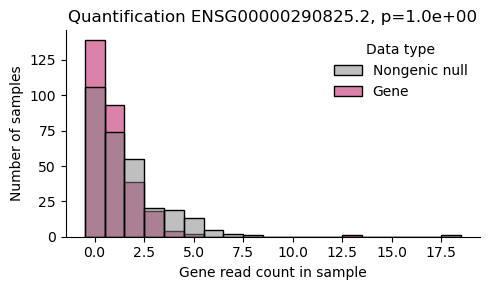

In [112]:
sample_gene_id = 'ENSG00000290825.2'
plot_matched_null(sample_gene_id)
v11_mean_tpm[v11_mean_tpm['gene_id'] == sample_gene_id]

,gene_id,tpm,gene_type_grouped,new_highlight_gene_type,quantified,matched_null_p


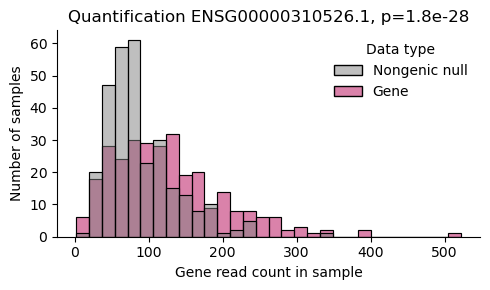

In [113]:
sample_gene_id = 'ENSG00000310526.1'
plot_matched_null(sample_gene_id)
v11_mean_tpm[v11_mean_tpm['gene_id'] == sample_gene_id]

In [ ]:
# add p values for all the genes
for idx, row in tqdm(v11_mean_tpm.iterrows(), total=len(v11_mean_tpm)):
    try:
        stat, p_value = stats.wilcoxon(v11_counts.loc[row['gene_id']].values, null_counts.loc[row['gene_id']].values, alternative='greater')
    except ValueError as e:
        # if all are 0 or all are the same, then it is not qunatified
        # could give p value of 1, or could give nan and investigate further
        p_value = np.nan
    v11_mean_tpm.loc[idx, 'matched_null_p'] = p_value

  0%|          | 0/74591 [00:00<?, ?it/s]

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<AxesSubplot: xlabel='matched_null_p', ylabel='Count'>

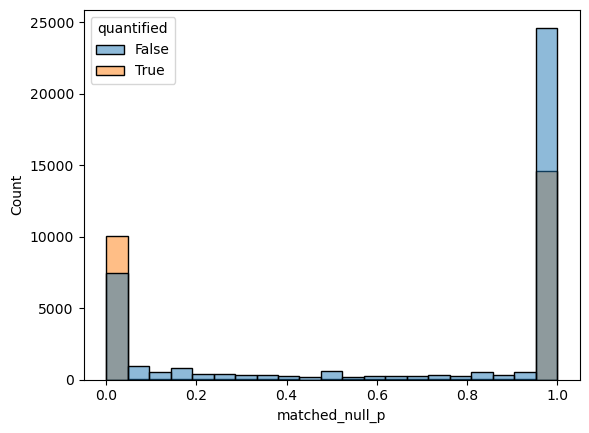

In [76]:
sns.histplot(v11_mean_tpm, x='matched_null_p', hue='quantified')

In [140]:
v11_mean_tpm[(v11_mean_tpm['quantified']) & (v11_mean_tpm['matched_null_p'] > .9)]

,gene_id,tpm,gene_type_grouped,new_highlight_gene_type,quantified,matched_null_p
13,ENSG00000268903.1,0.165532,pseudogene,pseudogene,True,0.993827
45,ENSG00000229376.3,0.162994,pseudogene,pseudogene,True,1.000000
70,ENSG00000303614.1,0.207811,lncRNA,new_lncRNA,True,0.998587
84,ENSG00000304965.1,0.189074,lncRNA,new_lncRNA,True,0.998503
118,ENSG00000301639.1,1.737824,lncRNA,new_lncRNA,True,1.000000
...,...,...,...,...,...,...
4968,ENSG00000298667.1,0.141439,lncRNA,new_lncRNA,True,1.000000
5014,ENSG00000287929.2,0.137583,lncRNA,new_lncRNA,True,1.000000
5094,ENSG00000116703.14,0.115361,protien_coding_or_TEC,protien_coding_or_TEC,True,1.000000
5862,ENSG00000297208.1,0.107903,lncRNA,new_lncRNA,True,1.000000


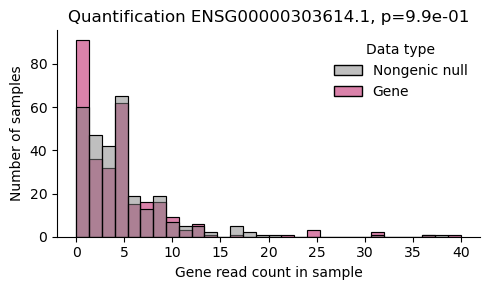

In [46]:
plot_matched_null('ENSG00000303614.1')

In [160]:
samples = pd.read_csv('data/other_references/caudate/caudate_samples_all.txt', header=None)

In [165]:
samples[0][~samples[0].isin(tpm_v10.columns[2:])]

20     GTEX-12WSH-0011-R5b-SM-5P9F3
111    GTEX-18464-0011-R5b-SM-718A6
196    GTEX-1RNSC-0011-R5a-SM-EZ6N5
198     GTEX-N7MT-0011-R5a-SM-2I3G6
203     GTEX-OXRN-0011-R5A-SM-2I5EF
204     GTEX-OXRO-0011-R5A-SM-2I5EG
205     GTEX-P44G-0011-R5A-SM-2I3FA
206     GTEX-P44H-0011-R5A-SM-2XCEX
213     GTEX-R55E-0011-R5A-SM-2TC5N
214     GTEX-RNOR-0011-R5A-SM-2TF4J
215     GTEX-RU72-0011-R5A-SM-2TF6U
216     GTEX-RVPV-0011-R5A-SM-2TF69
218     GTEX-S7SE-0011-R5A-SM-2XCDA
222     GTEX-TSE9-0011-R5A-SM-3DB7J
223     GTEX-UTHO-0011-R5A-SM-3GIJD
Name: 0, dtype: object

In [166]:
tpm_v10.columns[2:][~tpm_v10.columns[2:].isin(samples[0])]

Index(['GTEX-11TUW-0011-R5b-SM-5BC6Q', 'GTEX-13N2G-0011-R5a-SM-5MR33',
       'GTEX-15DDE-0011-R5b-SM-7KULJ', 'GTEX-1CB4J-0011-R5a-SM-9WG5Y',
       'GTEX-WHSE-0011-R5A-SM-3P5ZO'],
      dtype='object')